# CTGAN_on_data_train_engv3

Generate synthetic data from data_train 2011 to 2017 concatenated 

#### Objectifs :

- Générer des Tabular GANs : à partir du data_train, généré des instances qui s'y rapprochent, ensuite combiner les deux (data_train + generated_df) pour former un data_train perturbé ;

- Pratiquer un "Adversarial training" qui est l'une des défenses contre les "adversarial attacks" pour résister aux attaques fortes. (Surtout en cas de online service)

Adversarial training = Entraîner le modèle avec les tabular GANs pour le rendre robuste face à adversarial attacks.

In [1]:
import numpy as np
import pandas as pd
from ctgan import CTGANSynthesizer
from model import Model
import gc

from sklearn import metrics
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
list_column = ['salaire_mensuel_cleaned', 'anciennete_emploi_cleaned',
       'anciennete_bni_cleaned', 'categorie_employeur_cleaned_UNIQUEVAL',
       'mensualite_cleaned', 'argent_journalier',
       'taux_endettement_cleaned', 'salaire_vivable',
       'nb_salaires_cleaned', 'age_end', 'age_cleaned', 'nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned', 'duree_pret_cleaned', 'code_DTX_cleaned_UNIQUEVAL']

In [3]:
cat_col= ['categorie_employeur_cleaned_UNIQUEVAL','nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned','target']
cat_feat= [3,11,12,13,14]
num_col= ['salaire_mensuel_cleaned', 'anciennete_emploi_cleaned',
       'anciennete_bni_cleaned',
       'mensualite_cleaned', 'argent_journalier',
       'taux_endettement_cleaned', 'salaire_vivable',
       'nb_salaires_cleaned', 'age_end', 'age_cleaned', 'duree_pret_cleaned']

In [4]:
data_train = pd.read_csv('data/Version4/data_train_engv3_new.csv', delimiter=';')
data_train=data_train[list_column]
data_val = pd.read_csv('data/Version4/data_val_engv3_new.csv', delimiter=';')
data_val=data_val[list_column]
data_test = pd.read_csv('data/Version4/data_test_engv3_new.csv', delimiter=';')
data_test=data_test[list_column]

In [5]:
X_train = data_train.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
y_train = data_train['code_DTX_cleaned_UNIQUEVAL']
X_val = data_val.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
y_val = data_val['code_DTX_cleaned_UNIQUEVAL']
X_test = data_test.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
y_test = data_test['code_DTX_cleaned_UNIQUEVAL']

## Use of CTGAN to generate data (gan_xp)

In [12]:
def get_gan_dataset(x_train, y_train, x_test, cat_cols, gen_x_times=1.2, epochs=300):
    """
    Extends train by generating new data by GAN
    :param x_train:  train dataframe
    :param y_train: target for train dataframe
    :param x_test: dataframe
    :param cat_cols: List of categorical columns
    :param gen_x_times: Factor for which initial dataframe should be increased
    :param cat_cols: List of categorical columns
    :param epochs: Number of epoch max to train the GAN
    :return: generated data
    """

    if gen_x_times == 0:
        raise ValueError("Passed gen_x_times with value 0!")
    x_train["target"] = y_train
    x_test_bigger = int(10 * x_test.shape[0] / x_train.shape[0])
    print("x_test_bigger:",x_test_bigger)
    ctgan = CTGANSynthesizer()
    ctgan.fit(x_train, cat_cols, epochs=epochs)
    print("row numbers:",(x_test_bigger) * x_train.shape[0])
    generated_df = ctgan.sample((x_test_bigger) * x_train.shape[0])
    data_dtype = x_train.dtypes.values
    
    for i in range(len(generated_df.columns)):
        generated_df[generated_df.columns[i]] = generated_df[
            generated_df.columns[i]
        ].astype(data_dtype[i])
    
    return generated_df



In [13]:
gan_train = get_gan_dataset(X_train,y_train,X_test,cat_col)

x_test_bigger: 1


/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarn

GAN: Early stopping after epochs 41
row numbers: 22704


In [14]:
gan_train.shape

(22704, 17)

In [17]:
data_train.shape

(22704, 17)

In [18]:
gan_train

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target
0,1.914940e+05,37.944571,17.709209,0,44285.141070,3628.656057,32.508737,378808.371757,22.727388,27.655722,36.087344,0,1,1,0,23,0
1,2.333316e+05,127.158580,11.334504,1,302508.969021,15501.448994,30.861982,339285.976504,13.069038,33.589577,53.122457,1,3,1,0,35,0
2,1.511463e+05,41.884161,24.796347,1,50078.073405,3304.811285,32.226070,159114.002791,-0.861687,42.102806,29.785432,0,0,0,0,23,0
3,2.296516e+05,44.753738,29.555650,3,61002.019763,18679.301282,30.955218,444145.355981,68.843159,44.664738,34.554927,0,1,1,0,24,1
4,1.504683e+05,40.671100,14.660198,1,67073.348369,4236.614509,32.740655,99911.037060,2.229594,29.428244,37.621952,0,0,0,0,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22699,1.188991e+06,13.735245,61.952521,2,47018.610683,10692.666383,30.799049,222809.261474,71.501766,36.063276,59.094627,0,1,1,0,35,0
22700,7.239719e+05,66.953157,25.380880,0,53007.965072,4141.655748,32.890214,120645.557876,1.717164,44.960727,34.731675,0,0,0,0,23,0
22701,4.703949e+06,139.091401,118.740958,3,159630.154817,7582.072788,29.608916,392439.583049,68.479310,58.104736,36.836394,1,2,1,0,60,0
22702,2.171073e+05,11.458726,2.618750,0,63483.880784,4190.735444,33.027342,379100.888045,4.624492,42.366739,38.684961,0,0,0,0,47,0


In [19]:
gan_train.to_csv("results/dataset_gan_train.csv",sep=";")

### Import data gan test to avoid relaunch ctgan

In [29]:
gan_train = pd.read_csv("results/dataset_gan_train.csv",sep=";")

In [30]:
gan_train.shape

(22704, 18)

In [31]:
data_copy = gan_train.drop(["Unnamed: 0","salaire_vivable","argent_journalier","age_end" ,"target"],axis=1)

In [32]:
data_copy['salaire_vivable'] = data_copy['salaire_mensuel_cleaned'] - data_copy['mensualite_cleaned']
data_copy['argent_journalier']= data_copy['salaire_vivable']/30
data_copy['age_end'] = data_copy['age_cleaned'] + (data_copy['duree_pret_cleaned']/12)

In [33]:
gan_xp = data_copy

### Evaluation of gan_xp based on true labels

In [34]:
def evaluate(data_train, data_test, list_column):
    #Training data on all data train
    data_train_used = pd.DataFrame()
    data_train_used = data_train[list_column]
    #Training model on all data_train
    data_train_used_dum = pd.get_dummies(data_train_used)
    features_train = data_train_used_dum.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
    target_train = data_train_used_dum['code_DTX_cleaned_UNIQUEVAL']
    model = GradientBoostingClassifier(learning_rate=0.05)
    model.fit(features_train, target_train)
    
    
    data_test_dum = pd.get_dummies(data_test)
    data_test_used = pd.DataFrame()
    for column in data_train_used_dum.columns:
        try:
            data_test_used[column] = data_test_dum[column]
        except KeyError:
            data_test_used[column] = np.zeros(len(data_test_dum))
    features_test = data_test_used.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
    target_test = data_test_used['code_DTX_cleaned_UNIQUEVAL']
    pred = model.predict_proba(features_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(target_test, pred)
    plt.plot(fpr, tpr)
    plt.legend(labels=[metrics.auc(fpr, tpr)])
    plt.show()

In [35]:
def evaluate_cv(data, list_column):
    data_used = pd.DataFrame()
    data_used = data[list_column]
    #Removing year to list of columns
    
    X = data.drop('code_DTX_cleaned_UNIQUEVAL', axis=1).values
    y = data['code_DTX_cleaned_UNIQUEVAL'].values
    
    cv = KFold(n_splits=10,shuffle=True,random_state=42)
    GB = GradientBoostingClassifier(learning_rate=0.05)
    
    list_AUC = []
    list_abs = []
    i = 1
    for train, test in cv.split(X, y):
        GB.fit(X[train], y[train])
        pred = GB.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y[test], pred)
        list_AUC.append(metrics.auc(fpr, tpr))
        list_abs.append(i)
        i+=1
        plt.plot(fpr, tpr)
    print('Moyenne: ', np.mean(list_AUC))
    print('Std dev: ', np.std(list_AUC))
    plt.legend(labels=list_AUC)
    plt.show()

#### AUC of data_test

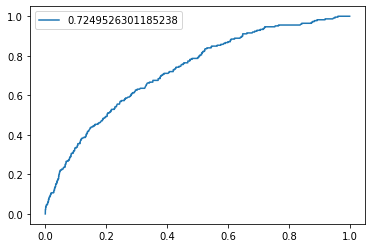

In [36]:
data = data_train
evaluate(data, data_test, list_column)

#### AUC of gan_xp with data_train labels

1687


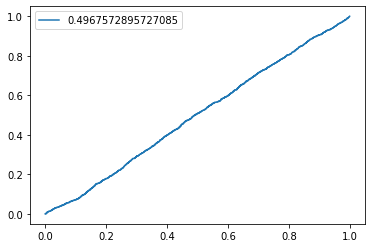

In [37]:
gan_xp['code_DTX_cleaned_UNIQUEVAL'] = data_train['code_DTX_cleaned_UNIQUEVAL']
print(gan_xp['code_DTX_cleaned_UNIQUEVAL'][gan_xp['code_DTX_cleaned_UNIQUEVAL'] == 1].count())
evaluate(data, gan_xp, list_column)

#### AUC of gan_xp with synth labels

In [38]:
gan_xp['code_DTX_cleaned_UNIQUEVAL'] = gan_train["target"]
#gan_xp.loc[gan_xp.code_DTX_cleaned_UNIQUEVAL >=1 , 'code_DTX_cleaned_UNIQUEVAL'] = 1
#gan_xp.loc[gan_xp.code_DTX_cleaned_UNIQUEVAL <1 , 'code_DTX_cleaned_UNIQUEVAL'] = 0
gan_xp['code_DTX_cleaned_UNIQUEVAL'][gan_xp['code_DTX_cleaned_UNIQUEVAL'] == 1].count()

1869

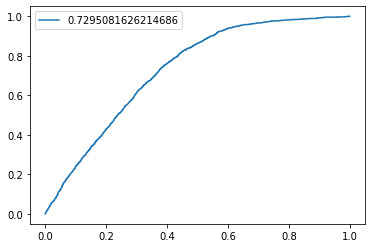

In [39]:
evaluate(data, gan_xp, list_column)

Moyenne:  0.8071052596221255
Std dev:  0.012271450626540198


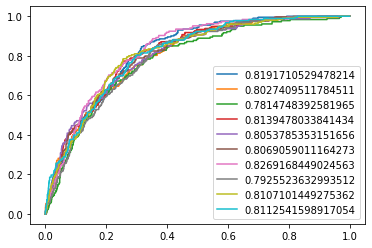

In [40]:
evaluate_cv(gan_xp,list_column)

### Try adversarial Training (data_train+data_synth) on data_test and data_synth_test
To improve model defense against adversarial attack

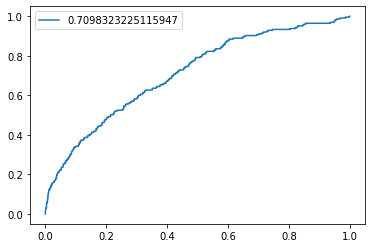

In [41]:
data_synth, data_synth_test = train_test_split(gan_xp, test_size=0.20, stratify=gan_xp['code_DTX_cleaned_UNIQUEVAL'])
data_extend = pd.concat([data_train,data_synth])
evaluate(data_extend, data_test, list_column)

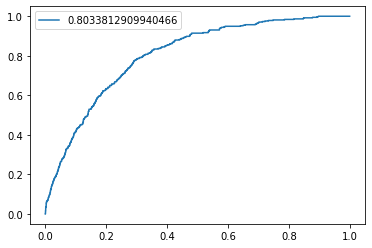

In [42]:
evaluate(data_extend, data_synth_test, list_column)

Moyenne:  0.7472826094120851
Std dev:  0.009892408455347283


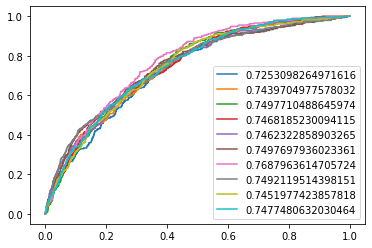

In [43]:
evaluate_cv(data_extend,list_column)

Constat : " La performance du modèle malgré l'ajout des instances synthétiques dans les données d'apprentissage n'améliore pas l'AUC sur l'évaluation du data_synth_test"

- Train : data_train 
    - AUC on data_test = 72
    - AUC on gan_xp (all data_synth) = 72.95


- Train : data_extend (data_train + 80% gan_xp)
    - AUC on data_test = 70.98
    - AUC on data_synth_test (20%) = 80.33
    
    
- CV :
    - CV on gan_xp = 80
    - CV on data_extend = 74.72 
    
TODO :
- Produire des datas synthétiques plus précis ; (use Adversarial test) 
____________________

## Methods for generating data for increasing train from "Diyago/GAN-for-tabular-data"

In [48]:
def extend_gan_train(x_train, y_train, x_test, cat_cols, num_cols ,gen_x_times=1.2, epochs=500):
    """
    Extends train by generating new data by GAN
    :param x_train:  train dataframe
    :param y_train: target for train dataframe
    :param x_test: dataframe
    :param cat_cols: List of categorical columns
    :param gen_x_times: Factor for which initial dataframe should be increased
    :param cat_cols: List of categorical columns
    :param epochs: Number of epoch max to train the GAN
    :return: extended train with target
    """

    if gen_x_times == 0:
        raise ValueError("Passed gen_x_times with value 0!")
    x_train["target"] = y_train
    x_test_bigger = int(11 * x_test.shape[0] / x_train.shape[0])
    print(x_test_bigger)
    ctgan = CTGANSynthesizer()
    ctgan.fit(x_train, cat_cols, epochs=epochs)
    generated_df = ctgan.sample((x_test_bigger) * x_train.shape[0])
    data_dtype = x_train.dtypes.values

    for i in range(len(generated_df.columns)):
        generated_df[generated_df.columns[i]] = generated_df[
            generated_df.columns[i]
        ].astype(data_dtype[i])

    generated_df = pd.concat(
        [
            x_train.sample(frac=(x_test_bigger), replace=True, random_state=42),
            generated_df,
        ]
    ).reset_index(drop=True)

    #num_cols = []
    #for col in x_train.columns:
    #    if "num" in col:
    #        num_cols.append(col)

    for num_col in num_cols:
        min_val = x_test[num_col].quantile(0.02)
        max_val = x_test[num_col].quantile(0.98)
        generated_df = generated_df.loc[
            (generated_df[num_col] >= min_val) & (generated_df[num_col] <= max_val)
        ]
    generated_df = generated_df.reset_index(drop=True)
    ad_model = adversarial_test(x_test, generated_df.drop("target", axis=1), cat_cols)

    generated_df["test_similarity"] = ad_model.predict(
        generated_df.drop("target", axis=1), return_shape=False
    )
    generated_df.sort_values("test_similarity", ascending=False, inplace=True)
    generated_df = generated_df.head(int(gen_x_times * x_train.shape[0]))
    x_train = pd.concat(
        [x_train, generated_df.drop("test_similarity", axis=1)], axis=0
    ).reset_index(drop=True)
    del generated_df
    gc.collect()
    return x_train.drop("target", axis=1), x_train["target"]



In [49]:
def adversarial_test(left_df, right_df, cat_cols):
    """
    Trains adversarial model to distinguish train from test
    :param left_df:  dataframe
    :param right_df: dataframe
    :param cat_cols: List of categorical columns
    :return: trained model
    """
    # sample to shuffle the data
    left_df = left_df.copy().sample(frac=1).reset_index(drop=True)
    right_df = right_df.copy().sample(frac=1).reset_index(drop=True)

    left_df = left_df.head(right_df.shape[0])
    right_df = right_df.head(left_df.shape[0])

    left_df["gt"] = 0
    right_df["gt"] = 1

    concated = pd.concat([left_df, right_df])
    lgb_model = Model(
        cat_validation="Single",
        encoders_names=("OrdinalEncoder",),
        cat_cols=cat_cols,
        model_validation=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        model_params={
            "metrics": "AUC",
            "max_depth": 2,
            "max_bin": 100,
            "n_estimators": 500,
            "learning_rate": 0.02,
            "random_state": 42,
        },
    )
    train_score, val_score, avg_num_trees = lgb_model.fit(
        concated.drop("gt", axis=1), concated["gt"]
    )

    print(
        "ROC AUC adversarial: train %.2f%% val %.2f%%"
        % (train_score * 100.0, val_score * 100.0)
    )
    return lgb_model

#### size to generate = 50% of size of data_test

In [50]:
cat_col_1 = ['categorie_employeur_cleaned_UNIQUEVAL','nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned']

In [51]:
data_extend_1, data_extend_1_target = extend_gan_train(X_train,y_train,X_test,cat_col_1,num_col,gen_x_times=0.5)

1


/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarn

GAN: Early stopping after epochs 42


/home/misa/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
/home/misa/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Referenc

Mean score train : 0.7197
Mean score val : 0.6871
ROC AUC adversarial: train 71.97% val 68.71%


In [52]:
data_extend_1['target'] = data_extend_1_target
data_extend_1.to_csv("results/data_train_extend.csv",sep=";")

### Import data gan test to avoid relaunch ctgan

In [53]:
gan_train = pd.read_csv("results/data_train_extend.csv",sep=";")

In [55]:
gan_train.shape

(34056, 18)

In [56]:
data_copy = gan_train.drop(["Unnamed: 0","salaire_vivable","argent_journalier","age_end" ,"target"],axis=1)

In [57]:
data_copy['salaire_vivable'] = data_copy['salaire_mensuel_cleaned'] - data_copy['mensualite_cleaned']
data_copy['argent_journalier']= data_copy['salaire_vivable']/30
data_copy['age_end'] = data_copy['age_cleaned'] + (data_copy['duree_pret_cleaned']/12)

In [58]:
gan_xp_1 = data_copy

#### AUC of gan_xp with synth labels

In [59]:
gan_xp_1['code_DTX_cleaned_UNIQUEVAL'] = gan_train["target"]
#gan_xp.loc[gan_xp.code_DTX_cleaned_UNIQUEVAL >=1 , 'code_DTX_cleaned_UNIQUEVAL'] = 1
#gan_xp.loc[gan_xp.code_DTX_cleaned_UNIQUEVAL <1 , 'code_DTX_cleaned_UNIQUEVAL'] = 0
gan_xp_1['code_DTX_cleaned_UNIQUEVAL'][gan_xp_1['code_DTX_cleaned_UNIQUEVAL'] == 1].count()

2049

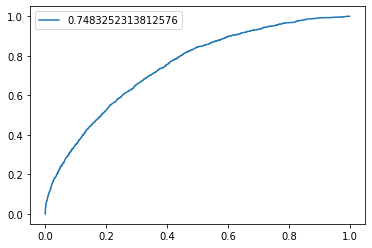

In [60]:
data = data_train
evaluate(data, gan_xp_1, list_column)

Moyenne:  0.7415392378204559
Std dev:  0.01674355920690312


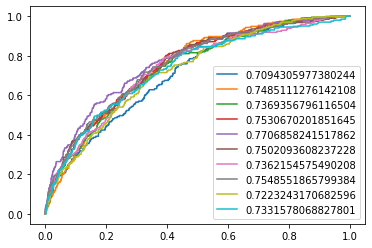

In [61]:
evaluate_cv(gan_xp_1,list_column)

### Try adversarial Training (data_extend_1) on data_test and data_synth_test
To improve model defense against adversarial attack

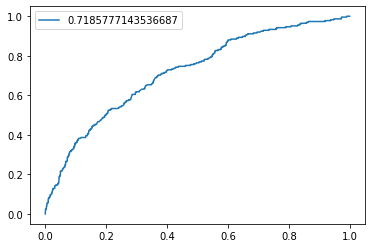

In [62]:
data_synth, data_synth_test = train_test_split(gan_xp_1, test_size=0.15, stratify=gan_xp_1['code_DTX_cleaned_UNIQUEVAL'])
evaluate(data_synth, data_test, list_column)

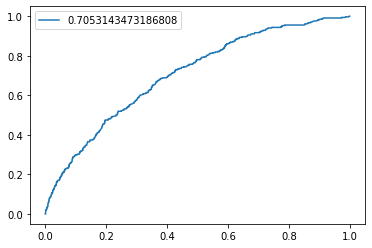

In [63]:
evaluate(data_synth, data_val, list_column)

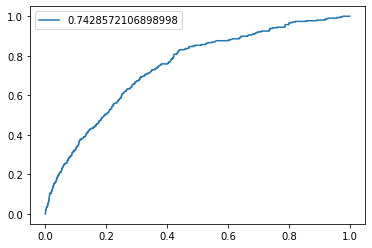

In [64]:
evaluate(data_synth, data_synth_test, list_column)

Moyenne:  0.7394823126462249
Std dev:  0.01269750581287609


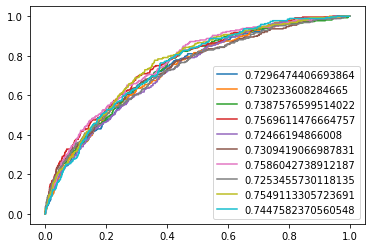

In [66]:
data_extend_train = pd.concat([gan_xp_1,data_test,data_val])
evaluate_cv(data_extend_train,list_column)

Constat :

- Train : data_train 
    - AUC on gan_xp_1 = 74 (A)  


- Train : data_synth (85% gan_xp_1)
    - AUC on data_test = 71  
    - AUC on data_val = 70     
    - AUC on data_synth_test (15%) = 74 --> Confirme le resultat de (A) 
    
<b>L'adversarial training (data_synth) montre que le modèle est robuste lorsqu'il est évalué sur data_synth_test.
    A confirmer avec d'autres adversarial examples</b>
    
    
- CV :
    - CV on gan_xp_1 = 74.15
    - CV on data_extend_train = 73.94 (gan_xp_1 + val + test)
    
TODO :
- Check for better split of data_synth and data_synth_test
____________________

In [67]:
gan_xp_1

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,taux_endettement_cleaned,nb_salaires_cleaned,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,salaire_vivable,argent_journalier,age_end,code_DTX_cleaned_UNIQUEVAL
0,338446.80,50.0,27.0,3,111010.550400,32.800000,25.0,38.0,0,0,0,0,48,227436.249600,7581.208320,42.0,1
1,203820.00,113.0,79.0,0,66587.994000,32.670000,73.0,45.0,1,0,0,0,30,137232.006000,4574.400200,47.5,0
2,581400.00,31.0,61.0,1,98663.580000,16.970000,55.0,34.0,0,0,1,0,24,482736.420000,16091.214000,36.0,0
3,607823.00,10.0,1.0,1,180766.560200,29.740000,1.0,42.0,0,0,0,0,36,427056.439800,14235.214660,45.0,0
4,138600.00,55.0,4.0,1,45682.560000,32.960000,3.0,48.0,0,2,1,0,24,92917.440000,3097.248000,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34051,378257.00,92.0,66.0,3,124711.332900,32.970000,50.0,36.0,1,4,1,0,60,253545.667100,8451.522237,41.0,0
34052,387302.60,133.0,76.0,3,126994.447098,32.789464,63.0,39.0,1,2,1,0,60,260308.152902,8676.938430,44.0,0
34053,392337.59,83.0,67.0,3,129353.703423,32.970000,63.0,33.0,1,0,0,0,60,262983.886577,8766.129553,38.0,0
34054,375670.00,119.0,68.0,3,123562.164744,32.891145,60.0,34.0,1,1,1,0,60,252107.835256,8403.594509,39.0,0


### Evaluation of data_synth based on predictions